# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## Project 1:
## Simulation of Property Prices in Ireland

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gamma
from scipy.stats import norm
import httpx
from selectolax.parser import HTMLParser
import time
import warnings
import random

In [2]:
# Set seed for reproducibility
np.random.seed(10)

# Number of samples
num_samples = 1200

### **Introduction**
For this data analytics project, I have chosen to simulate a dataset related to property prices in Ireland. 

I order to complete this I required some simple house statistics such as the average floor area and the minimum house price. The CSO (Central Statistic Office) only provides simulated datasets. Simulating data on another simulated dataset may not be ideal (in hindsight I should have just done this) so it was decided to scrape a sample number of properties on daft.ie, an Irish property website.

### **Variables**

1. Price
1. Floor Area
1. Bedrooms
1. Location

The scaper works by: geting the html -> extact the text -> parse the page -> cleaning the data

In [3]:
def get_html(baseurl, page):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"}
    resp = httpx.get(baseurl + str((page*20)-20), headers=headers)
    resp.raise_for_status()
    try:
        resp.raise_for_status()
    except httpx.HTTPStatusError as exc:
        print(f"Error response {exc.response.status_code} while requesting {exc.request.url!r}. Page Limit Exceeded")
        return False # Returns False when it exceeds the last webpage in order to stop the loop.
    html = HTMLParser(resp.text)
    return html

In [4]:
def extract_text(html, sel):
    try:
        text = html.css_first(sel).text(strip=True)
        return clean_data(text)
    except AttributeError:
        return None

In [5]:
def parse_page(html):
    card_elements = html.css("div[data-testid='card-body']")

    for card_element in card_elements:
        property_info = {
            "County": extract_text(card_element, "[data-testid='address']"),
            "Price": extract_text(card_element, "[data-testid='price']"),
            "Bedrooms": extract_text(card_element, "[data-testid='beds']"),
            "Bathrooms": extract_text(card_element, "[data-testid='baths']"),
            "Floor Area": extract_text(card_element, "[data-testid='floor-area']"),
            "Property Type": extract_text(card_element, "[data-testid='property-type']")
        }
        yield property_info

In [6]:
def clean_data(value):
    chars_to_remove = ["€", "m²", "Bed", "Bath", "ONLINE OFFERS", "ONLINE OFFER", "AMV:"]
    for char in chars_to_remove:
        if char in value:
            value = value.replace(char, "")
    return value.strip()

**Main function daft_scraper() to scrape the daft.ie property website.**

In [7]:
def daft_scraper(num_of_pages_to_scrape = 11):
    baseurl = "https://www.daft.ie/property-for-sale/ireland?pageSize=20&from="
    df_list = []
    
    print("Gathering Page:")
    for x in range(1,num_of_pages_to_scrape):
        print(f"{x}", end=" ")
        html = get_html(baseurl, x)
        if html is False:
            break
        data = parse_page(html)

        for item in data:
            df_list.append(item)
            
        time.sleep(0)

    scraped_df = pd.DataFrame(df_list)
    
    scraped_df["Price"] = pd.to_numeric(scraped_df["Price"].str.replace(",", ""), errors="coerce")
    scraped_df["Bedrooms"] = pd.to_numeric(scraped_df["Bedrooms"], errors="coerce")
    scraped_df["Bathrooms"] = pd.to_numeric(scraped_df["Bathrooms"], errors="coerce")
    scraped_df["Floor Area"] = pd.to_numeric(scraped_df["Floor Area"], errors="coerce")

    return scraped_df

In [8]:
scraped_df = daft_scraper(101)

Gathering Page:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

Transforming and cleaning the scraped data into a dataframe while also removing outliers.

In [9]:
df = pd.DataFrame()
df["Price"] = scraped_df["Price"].fillna(0).astype(int)
df["Bedrooms"] = scraped_df["Bedrooms"].fillna(0).astype(int)
df["Floor Area"] = scraped_df["Floor Area"].fillna(0).astype(int)
df["Property Type"] = scraped_df["Property Type"].astype("category")
df["County"] = scraped_df["County"].str.rsplit(',', n=2).str[-2]
df["County"] = df["County"].str.split('.', n=1).str[1]

df = df[(df["Price"] != 0) & (df["Bedrooms"] != 0) & (df["Floor Area"] != 0) & (df["Property Type"] != "Site") & (df["Price"] < 2_000_000) & (df["Floor Area"] < 500) & (df["Bedrooms"] <= 8)]

df.dropna(inplace=True)
df["Property Type"] = df["Property Type"].cat.remove_unused_categories()

df.reset_index(drop=True, inplace=True)

##### **Data Generation**

This function built for the fundamentals of data analysis and reused here. It is used to determine the best-fitting distribution to sample data. It uses built-in scipy functions to determine this. The lower the number the better fit.

**Function distribution_test(variable_name) to automatically identify the best-fitting distribution among multiple continuous variable candidates using Kolmogorov–Smirnov Test (KS), P-Values, and Akaike Information Criterion (AIC)**

In [10]:
def distribution_test(variable_name):
    
    results = []  # To store the results
    numpy_distributions = ['beta', 'chi2', 'expon', 'f', 'gamma', 'gumbel_r', 'gumbel_l', 'laplace', 'logistic', 'lognorm', 'norm', 'pareto', 
                           'powerlaw', 'powerlognorm', 'rayleigh', 'cauchy', 'exponpow', 't', 'triang', 'uniform', 'wald', 'weibull_min', 'weibull_max']

    for distribution in numpy_distributions:
        params = getattr(stats, distribution).fit(variable_name)
        stat, p_value = stats.kstest(variable_name, distribution, args=params)
        
        # Calculate AIC
        dist = getattr(stats, distribution)(*params)
        log_likelihood = dist.logpdf(variable_name).sum()
        k = len(params)  # Number of parameters
        aic = 2 * k - 2 * log_likelihood
        
        # Store the results in a dictionary
        result = {
            'Distribution': distribution,
            'KS Statistic': stat,
            'P-value': p_value,
            'AIC': aic
        }
        results.append(result)

    # Create a DataFrame from the results
    test_df = pd.DataFrame.from_dict(results)
    test_df = test_df.sort_values(by='KS Statistic', ascending=True).reset_index(drop=True).head(10)
    
    return test_df

In [11]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### **Variable 1: Price**

This variable represents the market value of a property. It is a continuous variable with a positive integer data type.

The price data was too wide ranging. It was transformed into a logarithmic scale.

In [12]:
transformed_price = np.log(df["Price"])

In [13]:
distribution_test(transformed_price)

,Distribution,KS Statistic,P-value,AIC
0,logistic,0.030068,0.359397,1618.323289
1,gamma,0.031903,0.290976,1624.709192
2,f,0.032572,0.268473,1626.512942
3,lognorm,0.032648,0.266020,1624.947519
4,t,0.033218,0.247989,1624.351594
5,norm,0.033229,0.247664,1622.370435
6,powerlognorm,0.033692,0.233711,1625.871681
7,beta,0.034809,0.202511,1626.310288
8,weibull_min,0.053406,0.009295,1652.870376
9,laplace,0.056474,0.004935,1674.920030


Depending the number of samples scraped from daft.ie this can change. As it is consistantly in the top three, It was decided that a lognormal probability distibution would fit and be accurate to simulate property prices.

According to the properties scraped the mean and standard deviation was determined and a lognormal probability distibution was complied from this.

In [14]:
mean_price = df["Price"].mean()
sigma_price = df["Price"].std()

# Convert these parameters to the mean of the log-normal distribution
mean_log = np.log(mean_price**2 / np.sqrt(mean_price**2 + sigma_price**2))
sigma_log = np.sqrt(np.log(1 + (sigma_price**2 / mean_price**2)))

simulated_house_price = np.random.lognormal(mean_log, sigma_log, num_samples)

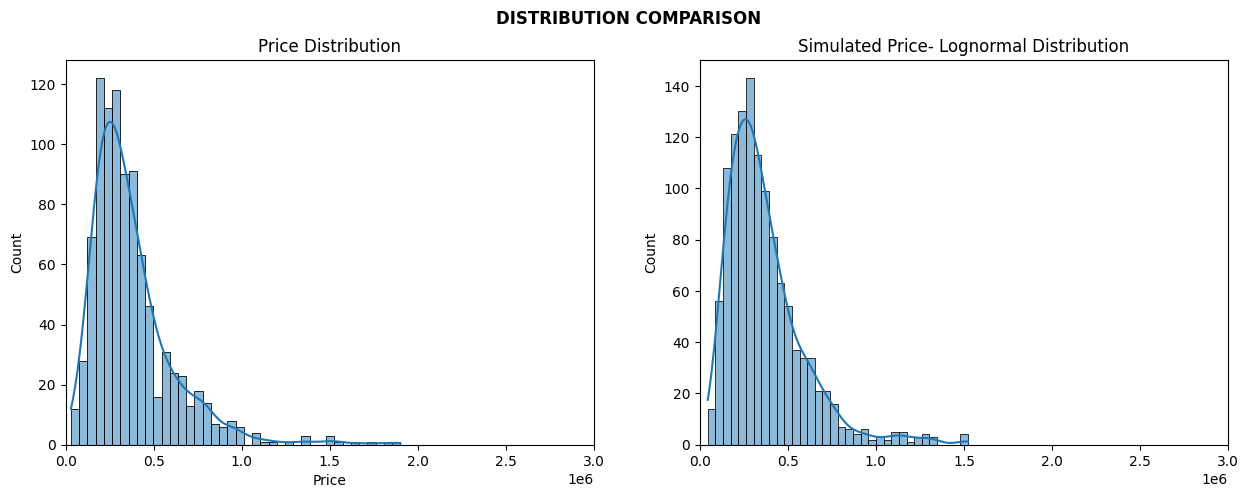

In [15]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Price Distribution')
axes[0].set_xlim(0, 3_000_000)
sns.histplot(df["Price"], kde=True, ax=axes[0])

axes[1].set_title('Simulated Price- Lognormal Distribution')
axes[1].set_xlim(0, 3_000_000)
sns.histplot(simulated_house_price, kde=True, ax=axes[1]);

### **Floor Area:**

The floor area of the property is in meters squared. This will be a continuous positive integer data type.

The floor area was also too wide ranging. It was transformed into a logarithmic scale.

In [16]:
transformed_floor_area = np.log(df["Floor Area"])

In [17]:
distribution_test(transformed_floor_area)

,Distribution,KS Statistic,P-value,AIC
0,logistic,0.036587,0.159592,1302.622562
1,chi2,0.037237,0.145849,1285.811498
2,weibull_min,0.038667,0.118956,inf
3,powerlognorm,0.041602,0.076416,1283.605730
4,gamma,0.042506,0.066244,1282.348176
5,lognorm,0.042670,0.064524,1282.249769
6,f,0.042704,0.064173,1284.261907
7,beta,0.043419,0.057166,1284.407345
8,weibull_max,0.044180,0.050432,1282.569424
9,t,0.046992,0.031156,1282.709853


Depending the number of samples scraped from daft.ie this can change. As it is consistantly in the top four, It was decided that a gamma probability distibution would fit and be accurate to simulate floor areas. Additionally chi squares seems to be only used to determine goodness of fit.

This code uses the gamma.fit function from SciPy to estimate the shape, location, and scale parameters of the gamma distribution that best fit the floor area data.

In [18]:
alpha, loc, beta = stats.gamma.fit(df["Floor Area"])

# Generate random samples from the fitted distribution
simulated_floor_area = gamma.rvs(alpha, loc=loc, scale=beta, size=num_samples)

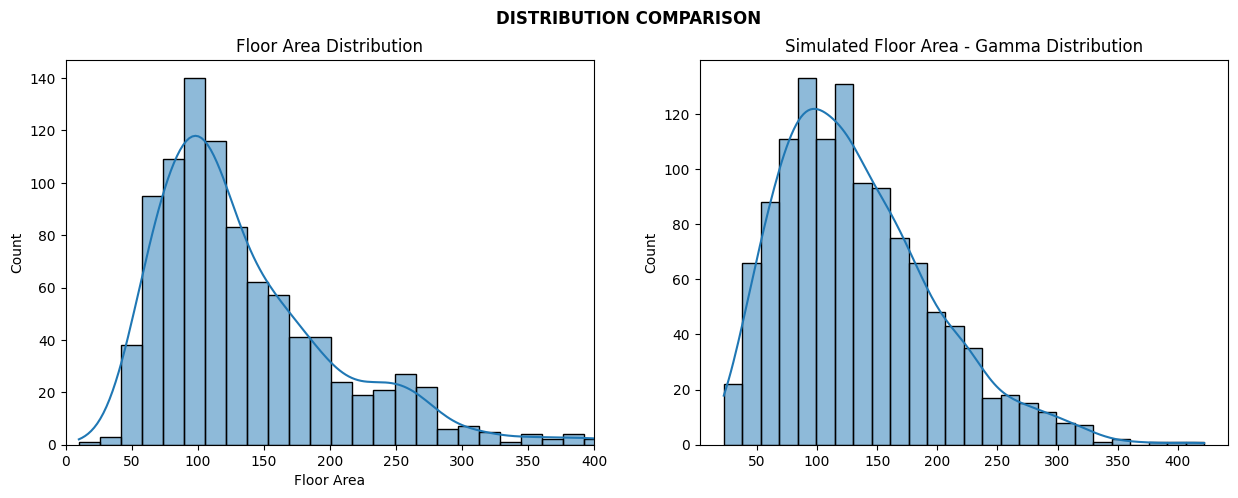

In [19]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Floor Area Distribution')
axes[0].set_xlim(0, 400)
sns.histplot(df["Floor Area"], kde=True, ax=axes[0])

axes[1].set_title('Simulated Floor Area - Gamma Distribution')
sns.histplot(simulated_floor_area, kde=True, ax=axes[1]);

#### **Bedrooms:**

The count of bedrooms in a property. This will be a discrete positive integer.

Using the scraped data as a basis, a simulated distibution of the nubmer of bedrooms was made. Random noise was also added so that it did not match perfectly.

In [42]:
# Get the count of each unique value in the 'Bedrooms' column
count_of_bedrooms = df["Bedrooms"].value_counts()

# Calculate the sum of bedrooms
sum_of_bedrooms = count_of_bedrooms.sum()

# Calculate the distribution of bedrooms
bedroom_distribution = (count_of_bedrooms / sum_of_bedrooms).sort_index()

# Convert the distribution to a list
p = bedroom_distribution.tolist()

# Simulate the number of bedrooms without noise based on the distribution
simulated_number_of_bedroom_without_noise = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8], size=num_samples, p=p)

# Add random noise to the simulated bedrooms
noise = np.random.randint(-1, 2, num_samples)
simulated_number_of_bedrooms = np.clip(simulated_number_of_bedroom_without_noise + noise, 1, 8)

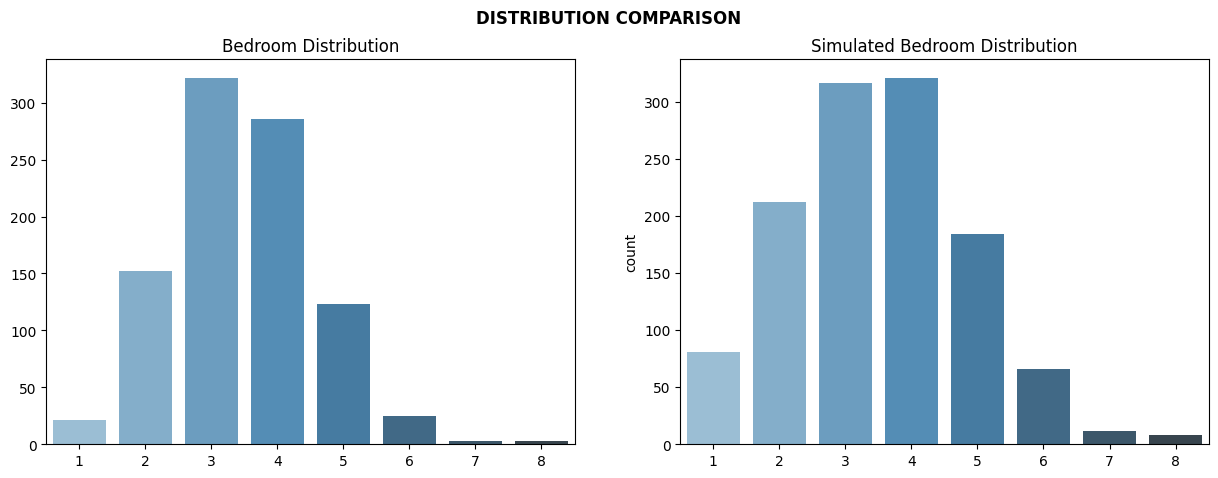

In [43]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Bedroom Distribution')
sns.barplot(x=count_of_bedrooms.index,y=count_of_bedrooms.values, palette='Blues_d', ax=axes[0])

axes[1].set_title('Simulated Bedroom Distribution')
sns.countplot(x=simulated_number_of_bedrooms, palette='Blues_d', ax=axes[1]);

### **Location**

The location of the propery. This is a categorical discrete variable with usually a string data type. In Pandas there is categorical data type so this was used.

In [23]:
price_by_county = df.groupby("County")["Price"].agg(['mean', 'std']).round(2)
price_by_county_df = price_by_county.reset_index().sort_values(by="mean", ascending=False)

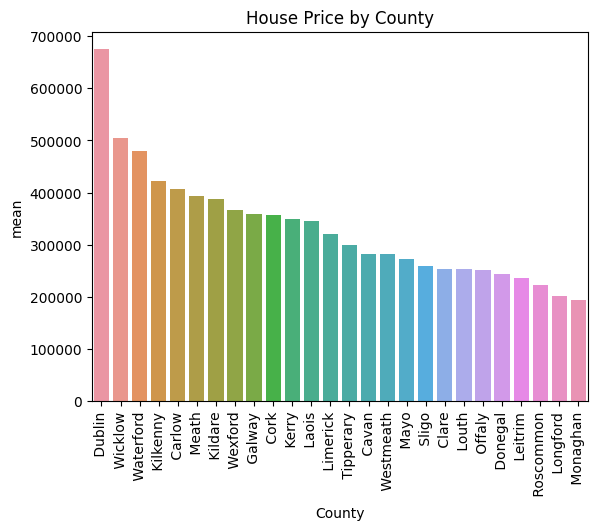

In [24]:
plt.title("House Price by County")
plt.xticks(rotation=90)
sns.barplot(x="County", y="mean", data=price_by_county_df);

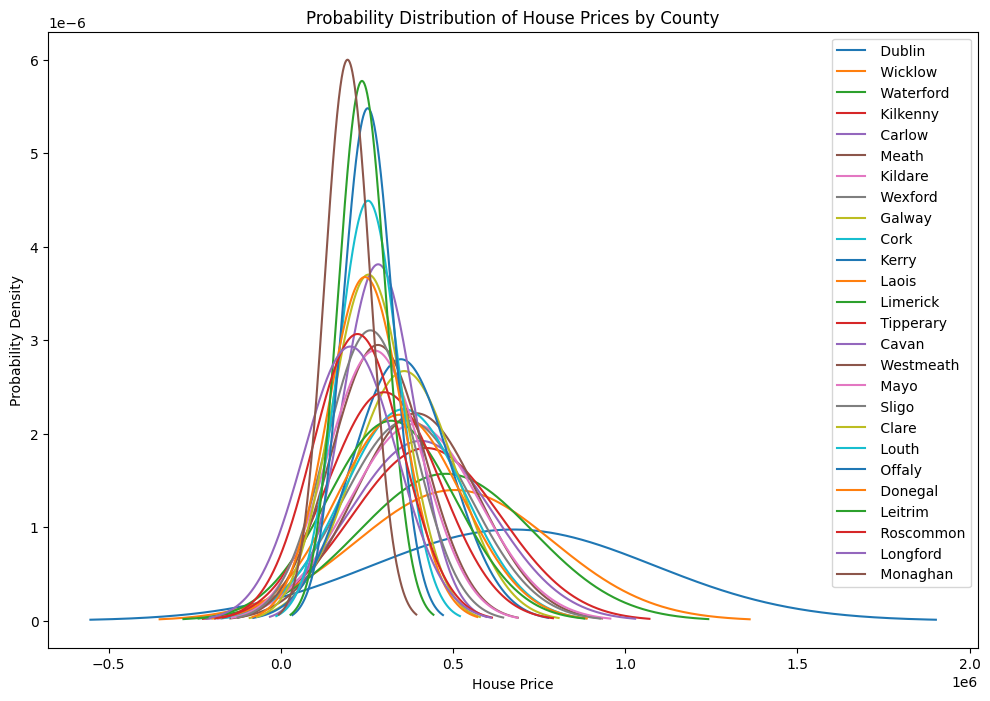

In [25]:
plt.figure(figsize=(12, 8))

for i, row in price_by_county_df.iterrows():
    mean = row['mean']
    std = row['std']

    dist = norm(loc=mean, scale=std)

    x = np.linspace(mean - 3 * std, mean + 3 * std, 1000)
    y = dist.pdf(x)
    plt.plot(x, y, label=row['County'])

plt.title('Probability Distribution of House Prices by County')
plt.xlabel('House Price')
plt.ylabel('Probability Density')
plt.legend();

Creating fake counties for the simulated data.

In [28]:
list_counties = []

for i in range(11):
    county = 'Simulated_County ' + str(i)
    list_counties.append(county)

counties_list_length = num_samples

simulated_counties = random.choices(list_counties, k=counties_list_length)

In [29]:
simulated_df = pd.DataFrame({
    'Simulated County': simulated_counties,
    'Simulated Price': simulated_house_price,
    'Simulated Bedrooms': simulated_number_of_bedrooms,
    'Simulated Floor Area': simulated_floor_area
})

### **Relationships**

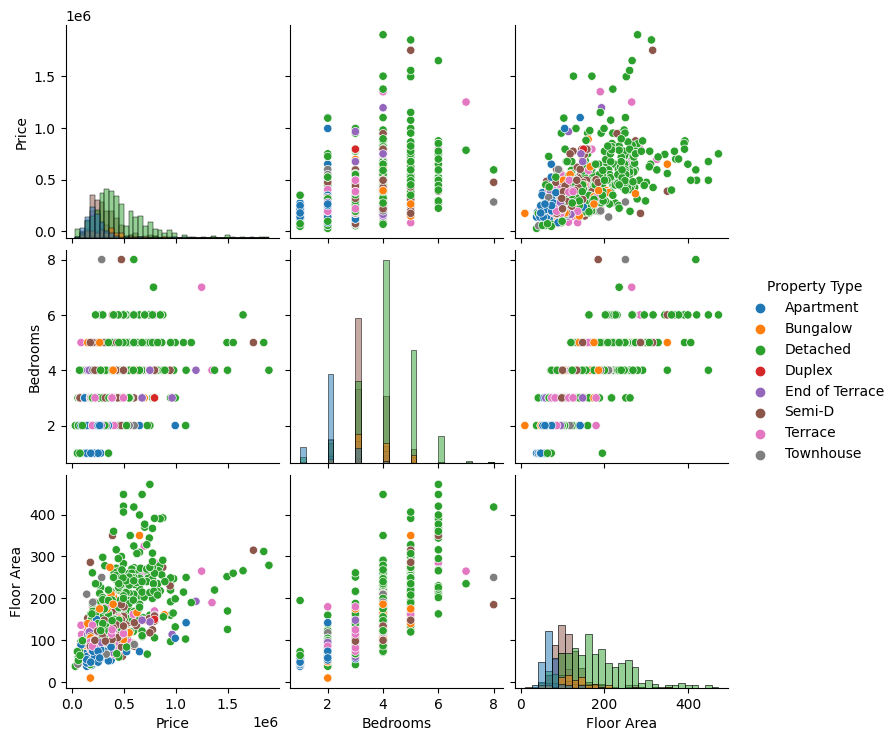

In [55]:
sns.pairplot(df, hue="Property Type", diag_kind='hist');

<Axes: title={'center': 'Heatmap: Correlation'}>

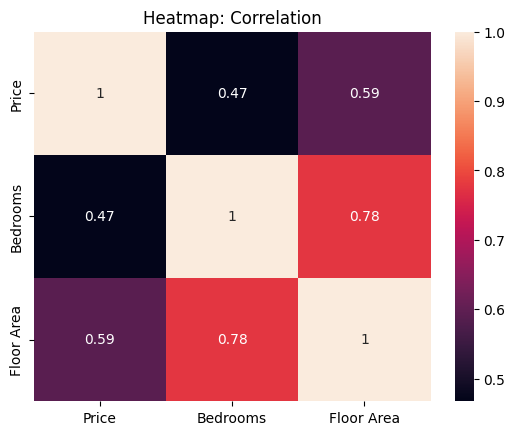

In [56]:
df_corr = df[['Price','Bedrooms','Floor Area']].corr()
plt.title('Heatmap: Correlation')
sns.heatmap(df_corr, annot=True)

### **Simulated Dataset First Look**

Upon initial examination of the simulated dataset, it appears to be accurate, with each variable displaying realistic values.

In [47]:
simulated_df.describe()

,Simulated Price,Simulated Bedrooms,Simulated Floor Area
count,1.200000e+03,1200.000000,1200.000000
mean,3.703165e+05,3.456667,133.075523
std,2.221950e+05,1.350793,64.304976
min,4.556456e+04,1.000000,22.459281
25%,2.202466e+05,3.000000,85.553639
50%,3.157959e+05,3.000000,122.047276
75%,4.560664e+05,4.000000,169.780339
max,1.521371e+06,8.000000,421.939264


It aligns with the sample dataset.

In [31]:
df.describe()

,Price,Bedrooms,Floor Area
count,9.350000e+02,935.000000,935.000000
mean,3.764757e+05,3.470588,136.654545
std,2.404680e+05,1.112004,70.445412
min,3.000000e+04,1.000000,10.000000
25%,2.194750e+05,3.000000,88.000000
50%,3.150000e+05,3.000000,116.000000
75%,4.500000e+05,4.000000,167.500000
max,1.900000e+06,8.000000,472.000000


However, the correlation between the sample and the simulated dataset is entirely different.

In [32]:
correlation_matrix = df[["Price", "Bedrooms", "Floor Area"]].corr(method='pearson', min_periods=1)

correlation_matrix

,Price,Bedrooms,Floor Area
Price,1.000000,0.467397,0.591029
Bedrooms,0.467397,1.000000,0.776760
Floor Area,0.591029,0.776760,1.000000


In [33]:
simulated_correlation_matrix = simulated_df[["Simulated Price", "Simulated Bedrooms", "Simulated Floor Area"]].corr(method='pearson', min_periods=1)

simulated_correlation_matrix

,Simulated Price,Simulated Bedrooms,Simulated Floor Area
Simulated Price,1.000000,0.000204,0.003275
Simulated Bedrooms,0.000204,1.000000,-0.090448
Simulated Floor Area,0.003275,-0.090448,1.000000


After trying and failing to use the Cholesky decomposition, it was decided to split DataFrame into two sections and match them up in order to make the simulated dataset correlate better. 

The code below chops and changes the simulated dataframe into a high and low section for each variable. As there is slight positive correlation between variables in the sample dataset, this was attempted to be mirrored in the simulated dataset using this methodolgy.

In [34]:
# Calculate the percentiles for Simulated Price
price_percentile = np.percentile(simulated_df['Simulated Price'], 50)

# Split the DataFrame into two based on the percentile
low_price_df = simulated_df[simulated_df['Simulated Price'] <= price_percentile]
high_price_df = simulated_df[simulated_df['Simulated Price'] > price_percentile]

# Shuffle the rows of each category
shuffled_low_price = low_price_df.sample(frac=1).reset_index(drop=True)
shuffled_high_price = high_price_df.sample(frac=1).reset_index(drop=True)

# Extract the "Simulated Price" column from each shuffled DataFrame
simulated_price_low = shuffled_low_price['Simulated Price']
simulated_price_high = shuffled_high_price['Simulated Price']

# Calculate the number of rows in half
half = len(simulated_df) // 2

# Sort the DataFrame by 'Simulated Bedrooms'
simulated_df_sorted = simulated_df.sort_values(by='Simulated Bedrooms', ascending=True)

# Split the DataFrame into two sections based on 'Simulated Bedrooms'
low_bedrooms_df = simulated_df_sorted.iloc[:half]
high_bedrooms_df = simulated_df_sorted.iloc[half:]

# Shuffle the rows of each category
shuffled_low_bedrooms = low_bedrooms_df.sample(frac=1).reset_index(drop=True)
shuffled_high_bedrooms = high_bedrooms_df.sample(frac=1).reset_index(drop=True)

# Extract the "Simulated Bedrooms" column from each shuffled DataFrame
simulated_bedrooms_low = shuffled_low_bedrooms['Simulated Bedrooms']
simulated_bedrooms_high = shuffled_high_bedrooms['Simulated Bedrooms']

# Repeat the process for Simulated Floor Area
floor_area_percentile = np.percentile(simulated_df['Simulated Floor Area'], 50)
low_floor_area_df = simulated_df[simulated_df['Simulated Floor Area'] <= floor_area_percentile]
high_floor_area_df = simulated_df[simulated_df['Simulated Floor Area'] > floor_area_percentile]

# Shuffle the rows of each category
shuffled_low_floor_area = low_floor_area_df.sample(frac=1).reset_index(drop=True)
shuffled_high_floor_area = high_floor_area_df.sample(frac=1).reset_index(drop=True)

# Extract the "Simulated Floor Area" column from each shuffled DataFrame
simulated_floor_area_low = shuffled_low_floor_area['Simulated Floor Area']
simulated_floor_area_high = shuffled_high_floor_area['Simulated Floor Area']

# Concatenate the shuffled DataFrames for each category along rows
final_low = pd.concat([simulated_price_low, simulated_bedrooms_low, simulated_floor_area_low], axis=1)
final_high = pd.concat([simulated_price_high, simulated_bedrooms_high, simulated_floor_area_high], axis=1)

# Concatenate the final DataFrames for each category along rows
simulated_final_df = pd.concat([final_low, final_high], axis=0, ignore_index=True)

### **Final Simulated Dataset**

In [35]:
simulated_final_df

,Simulated Price,Simulated Bedrooms,Simulated Floor Area
0,296252.359509,2,100.685782
1,256388.314898,3,95.642837
2,205880.074576,2,74.722403
3,306375.737912,2,86.694619
4,267081.158191,3,86.979221
...,...,...,...
1195,491871.282085,6,177.408586
1196,624690.440213,4,209.266865
1197,423123.635364,4,205.628423
1198,559624.994384,5,123.823162


Following the above dataframe manipulation, the correlation appears to be more in line with the sample dataset and is more realistic in its relationships.

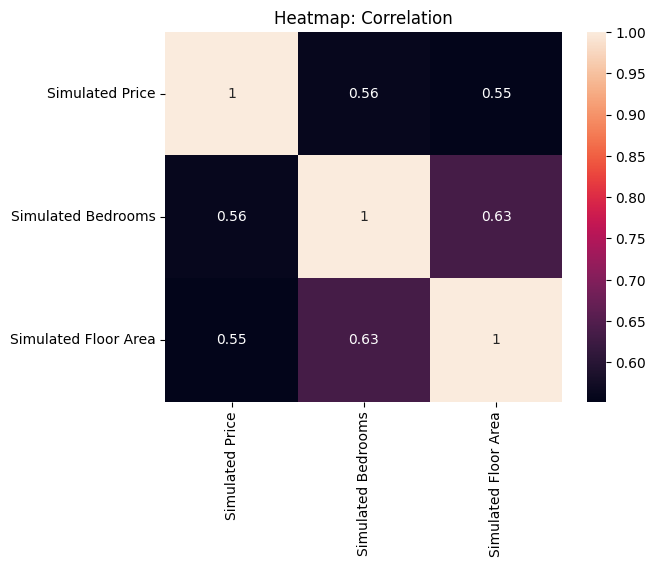

In [36]:
simulated_final_df_corr = simulated_final_df[['Simulated Price','Simulated Bedrooms','Simulated Floor Area']].corr()
plt.title('Heatmap: Correlation')
sns.heatmap(simulated_final_df_corr, annot=True);

The final look the a pairplot of the simulated dataset shows a good distribution, however, although the pearson coefficient looks correct, the scatterplot looks odd due to the methodogy used above.

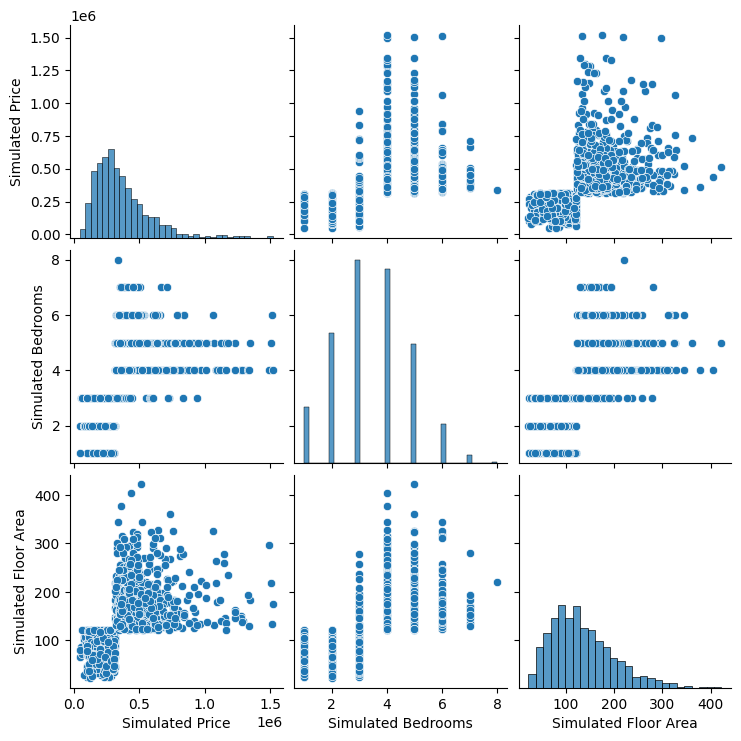

In [37]:
sns.pairplot(simulated_final_df);

### **References**


https://www.spcforexcel.com/knowledge/basic-statistics/deciding-which-distribution-fits-your-data-best/


https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/
https://statisticsbyjim.com/basics/goodness-of-fit/
https://statisticsbyjim.com/basics/skewed-distribution/

https://docs.scipy.org/doc/scipy/reference/stats.html

Note that this example covers continuous data. For categorical and discrete variables, you should use the chi-square goodness of fit test.

https://statisticsbyjim.com/hypothesis-testing/chi-square-goodness-of-fit-test/

https://archive.ph/20230811082152/https://towardsdatascience.com/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd#selection-643.182-653.170

https://www.datacamp.com/tutorial/probability-distributions-python

https://www.analyticsvidhya.com/blog/2021/09/q-q-plot-ensure-your-ml-model-is-based-on-the-right-distributions/https://archive.ph/20221125141253/https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f#selection-965.3-979.30

https://numpy.org/doc/1.16/reference/routines.random.html

https://stackoverflow.com/questions/45579525/returning-a-dataframe-in-python-function

https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/


https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart


https://stackoverflow.com/questions/69141790/seaborn-reg-plots-with-the-same-y-axis-scale-side-by-side


Right Skewed. The mean overestimates the most common values in a positively skewed distribution.

Using a QQ Plot to determine if the dristribution follows a probability distribution...?

https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_gumbel_l.html


https://www.statista.com/statistics/1417857/ireland-mean-new-home-size/

https://ec.europa.eu/eurostat/cache/digpub/housing/bloc-1b.html?lang=en

https://www.cso.ie/en/interactivezone/syntheticdata/housepricesyntheticdataset/

https://en.wikipedia.org/wiki/Parametric_statistics

https://www.youtube.com/@JohnWatsonRooney/videos

https://www.youtube.com/watch?v=1PCWwK0AsE0
https://www.youtube.com/watch?v=ZgVus_rmDBQ

https://visual.cso.ie/?body=entity/rppi

https://stackoverflow.com/questions/51607400/how-to-extract-first-8-characters-from-a-string-in-pandas

https://www.youtube.com/watch?v=xtTX69JZ92w

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponpow.html

https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

https://datatofish.com/convert-pandas-dataframe-to-list/

https://numpy.org/doc/stable/reference/generated/numpy.clip.html

https://en.wikipedia.org/wiki/Covariance_matrix

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cov.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html

https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3

https://pandas.pydata.org/docs/reference/api/pandas.qcut.html

***Add more references and sort them out.***

***
# End